# Imports & Functions 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import re

def asterisker(x):
    """ 
    Places significance *** at the correct positions in the heatmap
    """
    asterisk = ''
    if x <=0.001:
        asterisk = "***"
    elif x <=0.01:
        asterisk = "**"
    elif x <=0.05:
        asterisk = "*"
    return asterisk 

def peptide_namecleaner(peptide_name, pri=False):
    """
    Cleans peptide names before they are displayed on plots. 
    Prints Changes to quality check
    """    
    istailmod = re.search("_[A-Z]{5,}",peptide_name) # <-- determines if this is a tail modification
    if istailmod:           # if it is, then we go and replace that part. 
        peptide_name = peptide_name.replace(istailmod.group(),"_TailVar")
    
    
    removal_part = re.search(pattern="_[0-9]{,3}_[0-9]{,3}_",string=peptide_name)
    clean_pepname = peptide_name.replace(removal_part.group(),"_")
    if pri:
        print(f"{peptide_name} --> {clean_pepname}")
    return clean_pepname

# IMR575 Analysis

In [2]:
# load in dataframe containing results of the ANOVA as well as the fold changes averages and stds
data = pd.read_csv("IMR575_fc_anova_avg_pval.csv",index_col="Peptide").drop("Unnamed: 0",axis=1)

# first 4 cols are the adjusted p value for each modification
average = data.iloc[:,:4]
# next are the standard devs of each modification
sd = data.iloc[:,4:8]
# next are the fold changes between each condition
fc = data.iloc[:,8:14]
# finally are the adjusted p-values between each condition
p_adj = data.iloc[:,14:]

In [3]:
# load in dataframe containing results student t-test (for volcano plot)
t_test_pvals = pd.read_csv("IMR575_students.csv",index_col="Peptide")

### **Volcano plot**

In [4]:
# given we only want to compare control to DPI treatment, we filter for this in the fold-change dataframe
foldchange = fc[["DOX-DPI+/DOX-"]]

display(foldchange.head(3), t_test_pvals.head(3))

,DOX-DPI+/DOX-
Peptide,
H1_1_35_H12_SETAPAAPAAAPPAEKAPVKKKAAKKAGGTPR,0.838005
H1_1_35_H13_SETAPLAPTIPAPAEKTPVKKKAKKAGATAGKR,0.785089
H1_1_35_H14_SETAPAAPAAPAPAEKTPVKKKAR,1.117703


,p_val,fdr_padj
Peptide,,
H1_1_35_H12_SETAPAAPAAAPPAEKAPVKKKAAKKAGGTPR,0.506731,0.674047
H1_1_35_H13_SETAPLAPTIPAPAEKTPVKKKAKKAGATAGKR,0.570143,0.724236
H1_1_35_H14_SETAPAAPAAPAPAEKTPVKKKAR,0.428382,0.616022


In [5]:
# we merge these two dataframes on Peptide.  
# We also log2 transform both.
fc_pval = pd.merge(foldchange.apply(lambda x: np.log2(x)),
         t_test_pvals["p_val"].apply(lambda x: -np.log2(x)),
         on="Peptide")

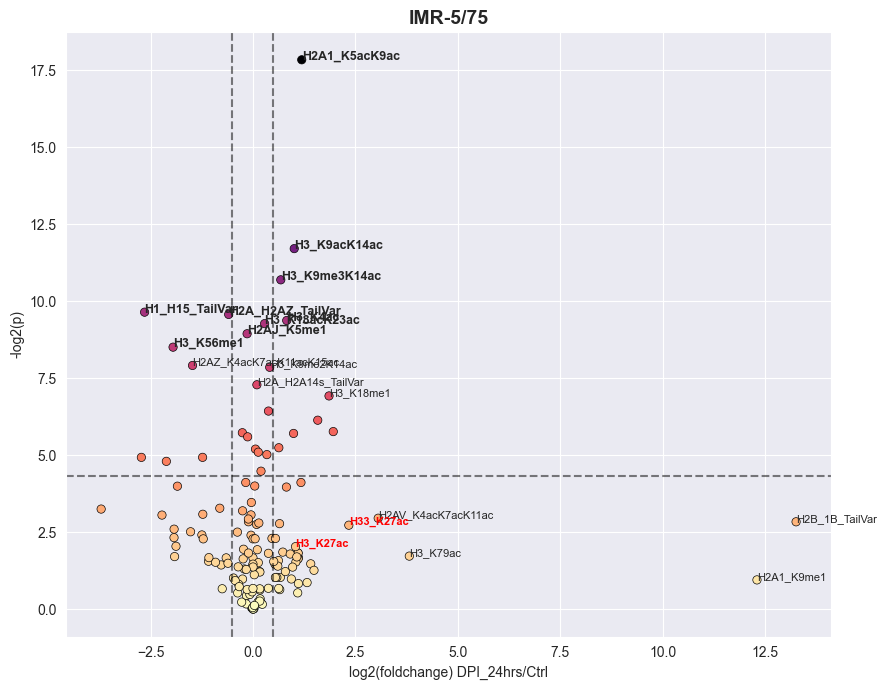

In [6]:
sns.set_style("darkgrid", )
plt.figure(figsize=(9,7))

sns.scatterplot(data=fc_pval,
        x= "DOX-DPI+/DOX-",
        y="p_val",
        hue="p_val",
        palette="magma_r",
        edgecolor="black"
        )


                 
plt.axvline(0.5, color="black", linestyle="--", alpha=0.5)
plt.axvline(-0.5, color="black",linestyle="--", alpha=0.5)
plt.axhline(-np.log2(0.05), color="black", linestyle="--", alpha=0.5)

interestinglist = ["H3_K9me2","H3_27_40_K27ac","H33_27_40_K27ac"]
for peptide in fc_pval.index:
    displaystring = peptide_namecleaner(peptide)
    
    if peptide in interestinglist:
        # if the peptide is one we want to look at
        plt.text(s=displaystring,
                y=fc_pval["p_val"].loc[peptide],
                x=fc_pval["DOX-DPI+/DOX-"].loc[peptide],
                fontsize=8,
                color="red",
                fontweight="bold")
        
    elif t_test_pvals["fdr_padj"].loc[peptide] <=0.05:
        # if the p-value is significant from correction
        plt.text(s=displaystring,
            y=fc_pval["p_val"].loc[peptide],
            x=fc_pval["DOX-DPI+/DOX-"].loc[peptide],
            fontsize=9,
            fontweight="bold")

    elif fc_pval["DOX-DPI+/DOX-"].loc[peptide] >3 or t_test_pvals["p_val"].loc[peptide] <=0.01:
        # if it has a big fold change or is really significant  

        plt.text(s=displaystring,
                 y=fc_pval["p_val"].loc[peptide],
                 x=fc_pval["DOX-DPI+/DOX-"].loc[peptide],
                 fontsize=8)

        




plt.legend().remove()
plt.ylabel("-log2(p)")
plt.xlabel("log2(foldchange) DPI_24hrs/Ctrl")
plt.title("IMR-5/75", fontsize=14,fontweight="bold")
plt.tight_layout()


plt.savefig("IMR575_volcanoplot.svg",dpi=600)
plt.show()
plt.close('all')


### **Heatmap With fold-changes**

In [7]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr


def spearman_dist(u, v):
    return 1 - spearmanr(u, v).correlation

In [15]:
heat_data

,NC-DPI 1h,NC-DPI 24h
Peptide,,
H1_54_81_H1T_VGMSLVALKKALAAAGYDVEKNNSR,0.014425,7.801127e-02
H2A1_12_17_K15me1,0.035221,2.844853e-01
H2A1_4_11_K5acK9ac,0.000106,1.230489e-03
H2A1_4_11_K5K9ac,0.002898,1.580911e-04
H2A1_4_11_K5me1,0.020747,8.271175e-02
H2AJ_4_11_K5K9ac,0.020476,8.988888e-02
H3_18_26_K18acK23ac,0.000294,8.238424e-04
H3_18_26_K18K23ac,0.021537,4.174601e-01
H3_27_40_K27me2K36me1,0.787479,2.893037e-02


In [18]:
heatfcs

,DPI 1h,DPI 24h
H1_H1T_TailVar,1.949914,1.626090
H2A1_K15me1,-0.790038,-0.394949
H2A1_K5acK9ac,-2.787058,-1.571674
H2A1_K5K9ac,-0.368432,-0.533679
H2A1_K5me1,-2.967072,-1.575952
H2AJ_K5K9ac,-2.502475,-1.372474
H3_K18acK23ac,-1.131998,-0.965274
H3_K18K23ac,-0.354572,-0.141284
H3_K27me2K36me1,0.612997,1.721855
H3_K4ac,-1.459440,-1.566102


C:\Users\Tim\AppData\Local\Temp\ipykernel_18096\3564000121.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sigmap = heat_data.applymap(asterisker)


new data labels are unique
new data labels are unique
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


C:\Users\Tim\AppData\Local\Temp\ipykernel_18096\3564000121.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  g.fig.tight_layout()


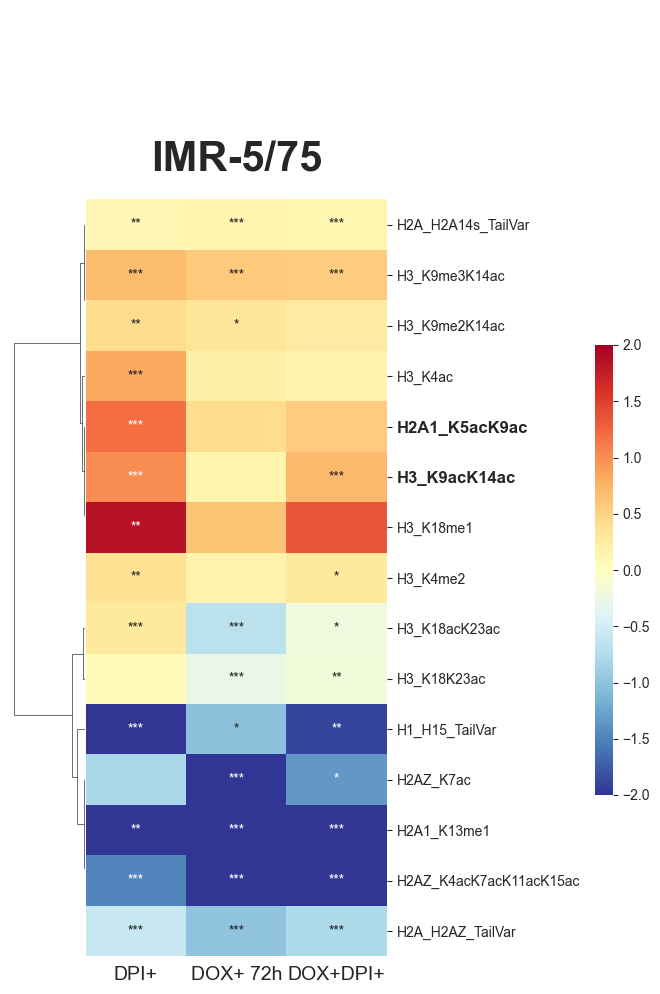

In [8]:
# filter for ANOVA p-values against the control. 
heat_data = p_adj[[col for col in p_adj if col.endswith("-DOX-")]].dropna()

# filter out unmod peptides (uninteresting) and also filter for only the significant values
heat_data = heat_data[~heat_data.index.str.contains("unmod")]
heat_data = heat_data[heat_data.lt(0.05).any(axis=1)]

top_sigs=heat_data.min(axis=1).sort_values()[:15].index
heat_data=heat_data.loc[top_sigs]

# Assign our significance *s to positions. 
sigmap = heat_data.applymap(asterisker)
# get the fold-changes and log transform them
heatfcs = fc[[col for col in fc.columns if col.endswith("/DOX-")]].loc[list(heat_data.index)].apply(np.log2)

# clean the peptide names 
heatfcs.index = [peptide_namecleaner(i) for i in heatfcs.index]
sigmap.index = [peptide_namecleaner(i) for i in sigmap.index]

# clean the column names 
heatfcs.columns = [i.replace("DOX-","").replace("/","") for i in heatfcs.columns]
sigmap.columns = [i.replace("DOX-","").replace("/","")  for i in sigmap.columns]

print(f"new data labels {'are' if heatfcs.index.is_unique else 'are NOT!!'} unique")
print(f"new data labels {'are' if sigmap.index.is_unique else 'are NOT!!'} unique")
print(sigmap.index==heatfcs.index)


g = sns.clustermap(heatfcs, 
               cmap="RdYlBu_r",
               center=0,
               annot=sigmap, 
               fmt="",
               col_cluster=False, 
               metric="cosine",
               figsize=(6, 10),
               vmin=-2,
               vmax=2
               )

g.ax_heatmap.set_title("IMR-5/75", fontsize=30,fontweight="bold", loc="center",pad=20)

g.cax.set_position([1, 0.2, 0.03, 0.45]) 
g.fig.tight_layout()



interesting_mods = ["H3_K9acK14ac","H2A1_K5acK9ac","H3_K9K14ac"]
for label in g.ax_heatmap.get_yticklabels():
    if label.get_text() in interesting_mods:  
        label.set_fontweight("bold")
        label.set_fontsize(12)   

for label in g.ax_heatmap.get_xticklabels():
    label.set_fontsize(14)   


g.savefig("IMR575_heatmap.svg", facecolor='white', bbox_inches='tight')



# Be2c Analysis 

In [9]:
data = pd.read_csv("Be2_fc_anova_avg_pval.csv",
            index_col="Peptide").drop("Unnamed: 0",axis=1)

average = data.iloc[:,:3]
sd = data.iloc[:,3:6]
fc = data.iloc[:,6:9]
p_adj = data.iloc[:,9:]

In [10]:
t_test_pvals = pd.read_csv("Be2_students.csv",
                           index_col="Peptide")

### **Volcano plot**

In [11]:
# given we only want to compare control to DPI treatment, we filter for this in the fold-change dataframe
foldchange = fc[["NC/DPI 24h"]].apply(lambda x:1/x)   # <- flip the fold change

display(foldchange.head(3), t_test_pvals.head(3))

,NC/DPI 24h
Peptide,
H1_1_35_H12_SETAPAAPAAAPPAEKAPVKKKAAKKAGGTPR,0.577601
H1_1_35_H13_SETAPLAPTIPAPAEKTPVKKKAKKAGATAGKR,1.059851
H1_1_35_H14_SETAPAAPAAPAPAEKTPVKKKAR,1.096302


,p_val,fdr_padj
Peptide,,
H1_1_35_H12_SETAPAAPAAAPPAEKAPVKKKAAKKAGGTPR,0.038393,0.292999
H1_1_35_H13_SETAPLAPTIPAPAEKTPVKKKAKKAGATAGKR,0.920170,0.946274
H1_1_35_H14_SETAPAAPAAPAPAEKTPVKKKAR,0.638565,0.782173


In [12]:
# we merge these two dataframes on Peptide.  
# We also log2 transform both.
fc_pval = pd.merge(foldchange.apply(lambda x: np.log2(x)),
         t_test_pvals["p_val"].apply(lambda x: -np.log2(x)),
         on="Peptide")

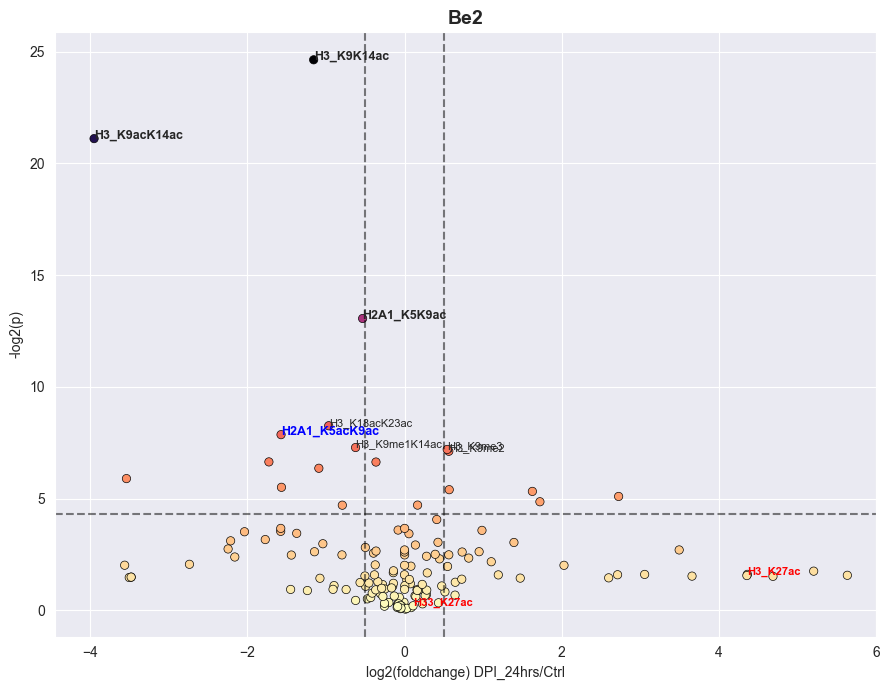

In [13]:
sns.set_style("darkgrid", )
plt.figure(figsize=(9,7))

sns.scatterplot(data=fc_pval,
        x= "NC/DPI 24h",
        y="p_val",
        hue="p_val",
        palette="magma_r",
        edgecolor="black"
        )

interestinglist = ["H3_9_17_K9ac","H3_27_40_K27ac","H33_27_40_K27ac"]



                 
plt.axvline(0.5, color="black", linestyle="--", alpha=0.5)
plt.axvline(-0.5, color="black",linestyle="--", alpha=0.5)
plt.axhline(-np.log2(0.05), color="black", linestyle="--", alpha=0.5)


for peptide in fc_pval.index:
    displaystring = peptide_namecleaner(peptide)
    

    if peptide in interestinglist:
        # if the peptide is one we want to look at
        plt.text(s=displaystring,
                y=fc_pval["p_val"].loc[peptide],
                x=fc_pval["NC/DPI 24h"].loc[peptide],
                fontsize=8,
                color="red",
                fontweight="bold")
        
    elif peptide=="H2A1_4_11_K5acK9ac":
            plt.text(s=displaystring,
                y=fc_pval["p_val"].loc[peptide],
                x=fc_pval["NC/DPI 24h"].loc[peptide],
                fontsize=9,
                color="blue",
                fontweight="bold")

        
    elif t_test_pvals["fdr_padj"].loc[peptide] <=0.05:
        # if the p-value is significant from correction
        plt.text(s=displaystring,
            y=fc_pval["p_val"].loc[peptide],
            x=fc_pval["NC/DPI 24h"].loc[peptide],
            fontsize=9,
            fontweight="bold")


    elif t_test_pvals["p_val"].loc[peptide] <=0.01:
        # if it has a big fold change or is really significant  

        plt.text(s=displaystring,
                 y=fc_pval["p_val"].loc[peptide],
                 x=fc_pval["NC/DPI 24h"].loc[peptide],
                 fontsize=8)
           



plt.xlim(fc_pval["NC/DPI 24h"].min()-.5,6)
plt.legend().remove()
plt.ylabel("-log2(p)")
plt.xlabel("log2(foldchange) DPI_24hrs/Ctrl")
plt.title("Be2", fontsize=14,fontweight="bold")
plt.tight_layout()

plt.savefig("Be2_volcanoplot.svg",dpi=600)
plt.show()

### **Heatmap With fold-changes**

C:\Users\Tim\AppData\Local\Temp\ipykernel_18096\1159241092.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sigmap = heat_data.applymap(asterisker)


new data labels are unique
new data labels are unique
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


<Figure size 640x480 with 0 Axes>

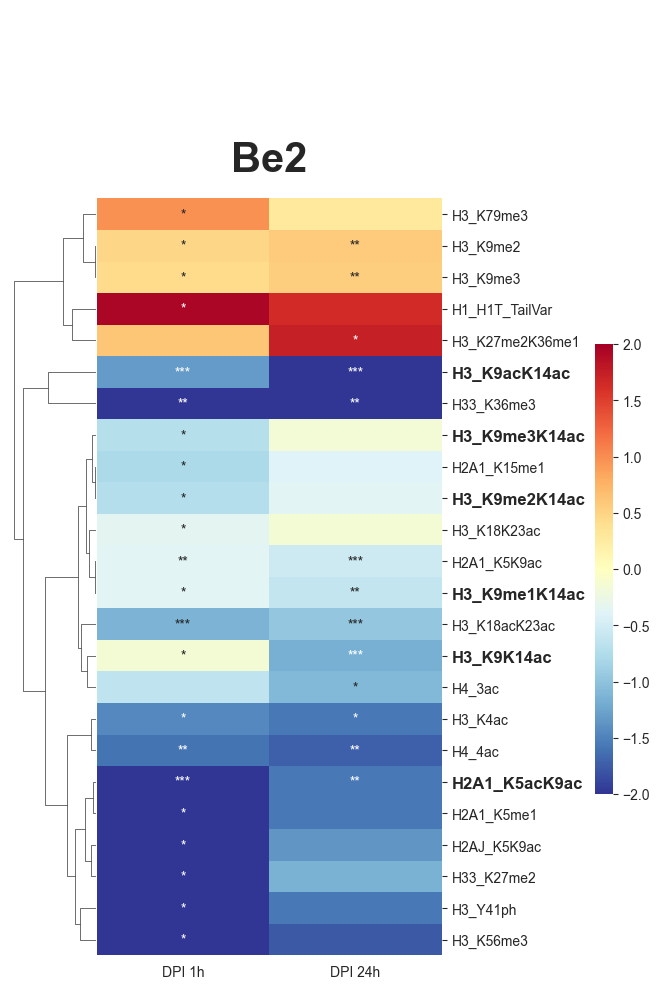

In [14]:
# filter for ANOVA p-values against the control. 
heat_data = p_adj[[col for col in p_adj if col.startswith("NC-")]].dropna()


# filter out unmod peptides (uninteresting) and also filter for only the significant values
heat_data = heat_data[~heat_data.index.str.contains("unmod")]
heat_data = heat_data[heat_data.lt(0.05).any(axis=1)]

# then filter for the top 15 most significant
#top_sigs=heat_data.min(axis=1).sort_values()[:15].index
#heat_data=heat_data.loc[top_sigs]

# Assign our significance *s to positions. 
sigmap = heat_data.applymap(asterisker)
# get the fold-changes and log transform them
heatfcs = fc[[col for col in fc.columns if col.startswith("NC/")]].loc[list(heat_data.index)].apply(lambda x:np.log2(1/x))
heatfcs.columns = [col.replace("NC","") for col in heatfcs.columns]

# clean the peptide names 
heatfcs.index = [peptide_namecleaner(i) for i in heatfcs.index]
sigmap.index = [peptide_namecleaner(i) for i in sigmap.index]

# clean the column names 
heatfcs.columns = [i.replace("DOX-","").replace("/","") for i in heatfcs.columns]
sigmap.columns = [i.replace("DOX-","").replace("/","")  for i in sigmap.columns]

print(f"new data labels {'are' if heatfcs.index.is_unique else 'are NOT!!'} unique")
print(f"new data labels {'are' if sigmap.index.is_unique else 'are NOT!!'} unique")
print(sigmap.index==heatfcs.index)

plt.figure()

g = sns.clustermap(heatfcs, 
               cmap="RdYlBu_r",
               center=0,
               annot=sigmap, 
               fmt="",
               col_cluster=False, 
               metric='cityblock',
               figsize=(6, 10),
               vmin=-2,
               vmax=2
               )

g.ax_heatmap.set_title("Be2", fontsize=30,fontweight="bold", loc="center",pad=20)

g.cax.set_position([1, 0.2, 0.03, 0.45]) 
#plt.title("log2[fold change]")


interesting_mods = ["H3_K9acK14ac","H2A1_K5acK9ac","H3_K9K14ac","H3_K9me1K14ac","H3_K9me2K14ac","H3_K9me3K14ac"]
for label in g.ax_heatmap.get_yticklabels():
    if label.get_text() in interesting_mods:  
        label.set_fontweight("bold")
        label.set_fontsize(12)   


plt.savefig("Be2_heatmap.svg",dpi=600)
plt.show()